In [10]:
import torch
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image

In [11]:
num_epochs = 20
batch_size = 128

In [12]:
# MNIST Dataset
train_dataset = datasets.MNIST(root='../app/mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='../app/mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=False, num_workers=1)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [4]:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True), 
            nn.Linear(64, 12), 
            nn.ReLU(True), 
            nn.Linear(12, 2)
        )
        self.decoder = nn.Sequential(
            nn.Linear(2, 12),
            nn.ReLU(True),
            nn.Linear(12, 64),
            nn.ReLU(True),
            nn.Linear(64, 128),
            nn.ReLU(True), 
            nn.Linear(128, 28 * 28), 
            nn.Tanh()
        )
        
    def forward(self, x):
        z = self.encoder(x)
        x = self.decoder(z)
        return z, x

In [5]:
model = autoencoder()
if torch.cuda.is_available():
    model.cuda()
    
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [6]:
print(model)

autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=64, out_features=12, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=12, out_features=2, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=12, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=12, out_features=64, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=64, out_features=128, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=128, out_features=784, bias=True)
    (7): Tanh()
  )
)


In [7]:
for epoch in range(1, num_epochs+1):
    train_loss = 0.0
    for data in train_loader:
        images, _ = data
        # flatten images
        images = images.view(images.size(0), -1)
        images = images.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        encoded, decoded = model(images)
        # calculate the loss
        loss = criterion(decoded, images)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*images.size(0)
            
    # print avg training statistics 
    train_loss = train_loss/len(train_loader)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch, 
        train_loss
        ))

Epoch: 1 	Training Loss: 7.768882
Epoch: 2 	Training Loss: 6.605583
Epoch: 3 	Training Loss: 6.093365
Epoch: 4 	Training Loss: 5.809709
Epoch: 5 	Training Loss: 5.632521
Epoch: 6 	Training Loss: 5.503933
Epoch: 7 	Training Loss: 5.406569
Epoch: 8 	Training Loss: 5.322495
Epoch: 9 	Training Loss: 5.244010
Epoch: 10 	Training Loss: 5.189346
Epoch: 11 	Training Loss: 5.156219
Epoch: 12 	Training Loss: 5.111284
Epoch: 13 	Training Loss: 5.085468
Epoch: 14 	Training Loss: 5.057946
Epoch: 15 	Training Loss: 4.999456
Epoch: 16 	Training Loss: 4.995369
Epoch: 17 	Training Loss: 4.966059
Epoch: 18 	Training Loss: 4.953388
Epoch: 19 	Training Loss: 4.951114
Epoch: 20 	Training Loss: 4.938480


In [8]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

with torch.no_grad():
    images_flatten = images.view(images.size(0), -1)
    images_flatten = images_flatten.cuda()
    # get sample outputs
    encoded, decoded = model(images_flatten)
    # prep images for display
    images = images.numpy()

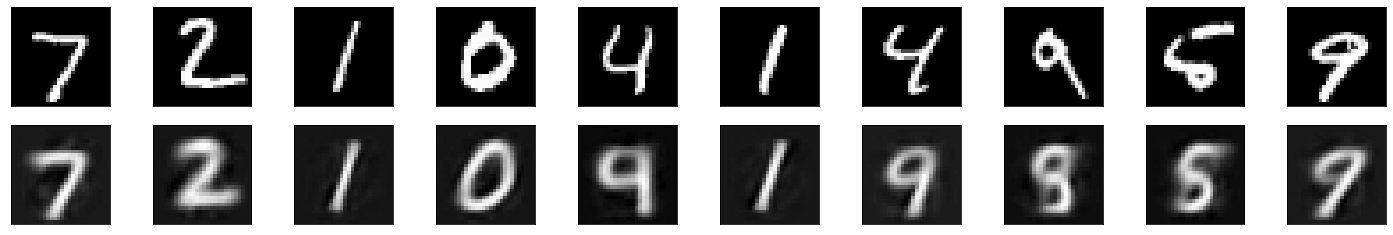

In [9]:
# output is resized into a batch of images
output = decoded.view(batch_size, 1, 28, 28)
# use detach when it's an output that requires_grad
output = output.detach().cpu().numpy()

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

# input images on top row, reconstructions on bottom
for images, row in zip([images, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)